# MLP on the CIFAR-10 Dataset

Trains three simple NNs with 3 hidden layers on the CIFAR-10 dataset.

Gets to 46.36% validation accuracy after 100 epochs (mean squared loss) (Residual Connection)

Gets to 47.03% validation accuracy after 100 epochs (mean squared loss) (MLP)

Gets to 54.5% validation accuracy after 100 epochs (cross-entropy loss) (MLP)

(there is *a lot* of margin for parameter tuning).

~ 4 seconds per epoch on a GTX1070 GPU.


## Import Tensorflow package (for Keras) and the CIFAR-10 dataset

In [1]:
from __future__ import print_function

# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import RMSprop
# from keras import regularizers

import tensorflow as tf

batch_size = 512
num_classes = 10
epochs = 100

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.reshape(50000, 3*32*32)
x_test = x_test.reshape(10000, 3*32*32)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

50000 train samples
10000 test samples


# The First Model (Residual Connection)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> Add Input -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [2]:
# model
x1 = tf.keras.layers.Input(shape=(3072,))
a1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(x1)
a2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(a1)
a2 = tf.keras.layers.Add()([a2, x1])
a3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(a2)
y_mlp = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(a3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model = tf.keras.models.Model(inputs=x1, outputs=y_mlp)

model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3072)         9440256     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3072)         9440256     dense_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 3072)         0           dense_2[0][0]                    
                                                                 input_1[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD)

In [3]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 95us/step - loss: 0.5404 - acc: 0.1676 - val_loss: 0.0907 - val_acc: 0.2257

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 64us/step - loss: 0.0885 - acc: 0.2571 - val_loss: 0.0866 - val_acc: 0.2768

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 64us/step - loss: 0.0855 - acc: 0.2998 - val_loss: 0.0846 - val_acc: 0.3091

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 64us/step - loss: 0.0838 - acc: 0.3238 - val_loss: 0.0831 - val_acc: 0.3305

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0826 - acc: 0.3409 - val_loss: 0.0822 - val_acc: 0.3453

Epoch 6/100
50000/50000 [==========

50000/50000 [==============================]50000/50000 [==============================] - 3s 65us/step - loss: 0.0734 - acc: 0.4567 - val_loss: 0.0747 - val_acc: 0.4341

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 65us/step - loss: 0.0733 - acc: 0.4574 - val_loss: 0.0746 - val_acc: 0.4364

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 65us/step - loss: 0.0732 - acc: 0.4588 - val_loss: 0.0745 - val_acc: 0.4373

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 64us/step - loss: 0.0731 - acc: 0.4604 - val_loss: 0.0744 - val_acc: 0.4398

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 64us/step - loss: 0.0730 - acc: 0.4608 - val_loss: 0.0744 - val_acc: 0.4383

Epoch 50/100
50000/50000 [==============================]50000/50000 [=======================

50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0703 - acc: 0.4915 - val_loss: 0.0725 - val_acc: 0.4597

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0702 - acc: 0.4926 - val_loss: 0.0725 - val_acc: 0.4580

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0702 - acc: 0.4931 - val_loss: 0.0724 - val_acc: 0.4606

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0701 - acc: 0.4941 - val_loss: 0.0724 - val_acc: 0.4614

Epoch 93/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0701 - acc: 0.4945 - val_loss: 0.0724 - val_acc: 0.4599

Epoch 94/100
50000/50000 [==============================]50000/50000 [=======================

## Loss and Accuracy Plots

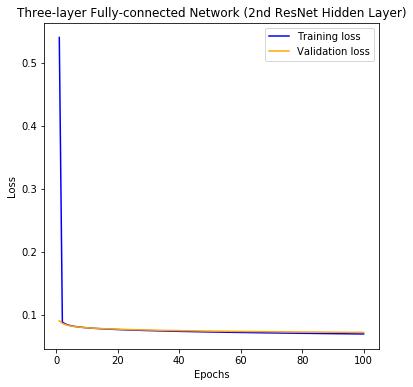

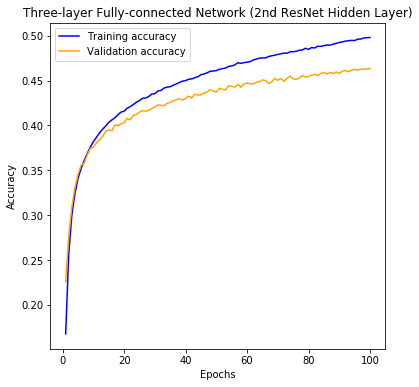

In [4]:
# Plot of Losses
import matplotlib.pyplot as plt

history_dict = history.history
# history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs_index = range(1,len(loss_values)+1)

fig_loss = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [5]:
fig_accuracy.savefig('fig_accuracy_cifar.eps', format='eps', dpi=2000)

# The Second Model (MLP)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [6]:
# model
x0 = tf.keras.layers.Input(shape=(3072,))
u1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(x0)
u2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(u1)
u3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(u2)
y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(u3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model_2 = tf.keras.models.Model(inputs=x0, outputs=y_mlp_2)

model_2.summary()

model_2.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_6 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_7 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30730     
Total params: 28,351,498
Trainable params: 28,351,498
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD)

In [7]:
history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_2 = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 0.0904 - acc: 0.2086 - val_loss: 0.0853 - val_acc: 0.2741

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0838 - acc: 0.3011 - val_loss: 0.0827 - val_acc: 0.3208

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0819 - acc: 0.3348 - val_loss: 0.0816 - val_acc: 0.3388

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0808 - acc: 0.3523 - val_loss: 0.0806 - val_acc: 0.3563

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0800 - acc: 0.3664 - val_loss: 0.0797 - val_acc: 0.3713

Epoch 6/100
50000/50000 [==========

50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0720 - acc: 0.4673 - val_loss: 0.0734 - val_acc: 0.4455

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0719 - acc: 0.4693 - val_loss: 0.0733 - val_acc: 0.4478

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0718 - acc: 0.4685 - val_loss: 0.0733 - val_acc: 0.4499

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0717 - acc: 0.4708 - val_loss: 0.0732 - val_acc: 0.4513

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0716 - acc: 0.4710 - val_loss: 0.0732 - val_acc: 0.4471

Epoch 50/100
50000/50000 [==============================]50000/50000 [=======================

50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0690 - acc: 0.5034 - val_loss: 0.0712 - val_acc: 0.4694

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0689 - acc: 0.5036 - val_loss: 0.0712 - val_acc: 0.4717

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0689 - acc: 0.5042 - val_loss: 0.0713 - val_acc: 0.4733

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0688 - acc: 0.5043 - val_loss: 0.0713 - val_acc: 0.4697

Epoch 93/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 63us/step - loss: 0.0688 - acc: 0.5050 - val_loss: 0.0716 - val_acc: 0.4682

Epoch 94/100
50000/50000 [==============================]50000/50000 [=======================

## Loss and Accuracy Plots

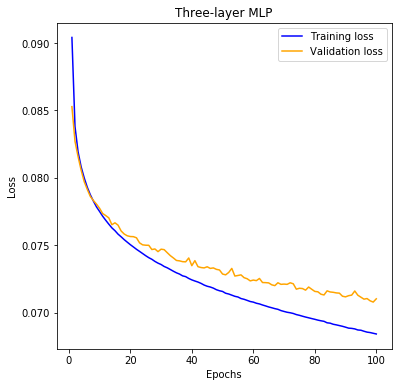

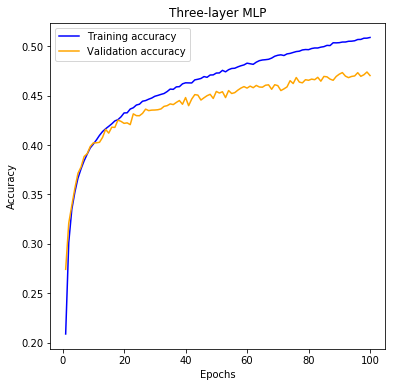

In [8]:
# Plot of Losses
history_dict_2 = history_2.history
# history_dict.keys()
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']
acc_values_2 = history_dict_2['acc']
val_acc_values_2 = history_dict_2['val_acc']

epochs_index = range(1,len(loss_values_2)+1)
fig_loss_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_2, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_2, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_2,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_2,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [9]:
fig_accuracy_2.savefig('fig_accuracy_cifar_2.eps', format='eps', dpi=2000)

# The Third Model (MLP) (Cross-entropy Loss)

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Softmax -> Cross-entropy loss

In [10]:
# model
z0 = tf.keras.layers.Input(shape=(3072,))
z1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z0)
z2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z1)
z3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z2)
#y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(z3)
y_mlp_3 = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=None)(z3)

model_3 = tf.keras.models.Model(inputs=z0, outputs=y_mlp_3)

model_3.summary()

model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_10 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_11 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                30730     
Total params: 28,351,498
Trainable params: 28,351,498
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Fit the Model using Back Propagation (Vanilla SGD)

In [11]:
history_3 = model_3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 4s 72us/step - loss: 2.0870 - acc: 0.2681 - val_loss: 1.9584 - val_acc: 0.3290

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 66us/step - loss: 1.9043 - acc: 0.3407 - val_loss: 1.8643 - val_acc: 0.3524

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 67us/step - loss: 1.8362 - acc: 0.3596 - val_loss: 1.8256 - val_acc: 0.3657

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 67us/step - loss: 1.7935 - acc: 0.3757 - val_loss: 1.7937 - val_acc: 0.3621

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 67us/step - loss: 1.7607 - acc: 0.3862 - val_loss: 1.7594 - val_acc: 0.3894

Epoch 6/100
50000/50000 [==========

50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.3631 - acc: 0.5290 - val_loss: 1.4279 - val_acc: 0.4987] - ETA: 1s 

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 69us/step - loss: 1.3560 - acc: 0.5297 - val_loss: 1.4520 - val_acc: 0.4804

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 69us/step - loss: 1.3475 - acc: 0.5319 - val_loss: 1.4238 - val_acc: 0.4918

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.3495 - acc: 0.5324 - val_loss: 1.4057 - val_acc: 0.5033

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 69us/step - loss: 1.3517 - acc: 0.5298 - val_loss: 1.4064 - val_acc: 0.4972

Epoch 50/100
50000/50000 [==============================]50000/50000 [===========

50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.1458 - acc: 0.6061 - val_loss: 1.3106 - val_acc: 0.5347

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.1456 - acc: 0.6079 - val_loss: 1.3034 - val_acc: 0.5398

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.1555 - acc: 0.6009 - val_loss: 1.3510 - val_acc: 0.5265

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.1263 - acc: 0.6144 - val_loss: 1.4481 - val_acc: 0.4999

Epoch 93/100
50000/50000 [==============================]50000/50000 [==============================] - 3s 68us/step - loss: 1.1378 - acc: 0.6087 - val_loss: 1.3492 - val_acc: 0.5251

Epoch 94/100
50000/50000 [==============================]50000/50000 [=======================

## Loss and Accuracy Plots

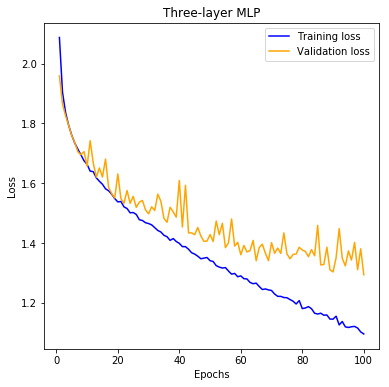

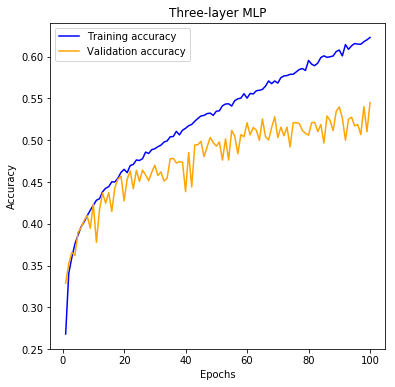

In [12]:
# Plot of Losses
history_dict_3 = history_3.history
# history_dict.keys()
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']
acc_values_3 = history_dict_3['acc']
val_acc_values_3 = history_dict_3['val_acc']

epochs_index = range(1,len(loss_values_3)+1)
fig_loss_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_3, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_3, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_3,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_3,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [13]:
fig_accuracy_3.savefig('fig_accuracy_cifar_3.eps', format='eps', dpi=2000)